# Requirement 3: Best-of-both-worlds algorithms with a single product

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from scipy.stats import truncnorm
from scipy.stats import truncexpon

### Definition of a Non Stationary Pricing Environment

We define three types of nonstationary pricing environments based on three different distributions over the valuation: a nonstationary Beta distribution, a nonstationary Truncated Normal distribution and a nonstationary Truncated Exponential distribution. We keep the valuation between 0 and 1 and the non-stationarity is achieved in the following way: we select at each round a change mode (jump, drift and spike) and we change the parameters of the distribution accordingly. "Jump" means uniformly resampling the parameters, "Drift" means increasing or decreasing each parameters, and "Spike" means producing a concentrated distribution, changing mean and covariance.

In [ ]:
class NonStationaryBetaEnv:
    """
    A highly non-stationary environment where:
    - Valuations are always in [0, 1]
    - The valuation distribution changes COMPLETELY at every round
    - Uses Beta distributions for flexibility in shape
    """
    
    def __init__(self, cost, prices, T):
        self.cost = cost
        self.prices = np.array(prices)
        self.T = T
        
        # Initial Beta distribution parameters (uniform)
        self.alpha = 1
        self.beta = 1
    
    def _update_distribution(self):
        """Drastically change the Beta distribution parameters at EVERY round"""
        change_mode = np.random.choice(['jump', 'drift', 'spike'])
        if change_mode == 'jump':
            # Sudden jump to new distribution
            self.alpha = np.random.uniform(0.1, 20)
            self.beta = np.random.uniform(0.1, 20)
            
        elif change_mode == 'drift':
            # Random walk drift
            self.alpha = np.clip(self.alpha * np.random.uniform(0.5, 1.5), 0.1, 20)
            self.beta = np.clip(self.beta * np.random.uniform(0.5, 1.5), 0.1, 20)
            
        else: # 'spike'
            # Create extreme distribution (very skewed)
            if np.random.rand() > 0.5:
                self.alpha = np.random.uniform(0.5, 1.5)  # Low valuations
                self.beta = np.random.uniform(10, 15)      # High skew
            else:
                self.alpha = np.random.uniform(10, 15)     # High skew
                self.beta = np.random.uniform(0.5, 1.5)   # High valuations
    
    
    def get_win_probability(self, t, price):
        '''Get the winning probability for a given price'''
        return 1 - stats.beta.cdf(price, self.alpha, self.beta)
    
    def get_win_probabilities(self, t):
        """Return an array of win probabilities for all prices at time t."""
        return np.array([self.get_win_probability(t, p) for p in self.prices])
    
    def round(self, t, n_customers, price):
        """
        Simulate a round at time t.
        Returns: (demand, revenue)
        """
        win_prob = self.get_win_probability(t, price)
        d_t = np.random.binomial(n_customers, win_prob)
        r_t = (price - self.cost) * d_t
        self._update_distribution()
        return d_t, r_t

In [ ]:
class NonStationaryTruncNormEnv:
    """
    A highly non-stationary environment where:
    - Valuations are always in [0, 1]
    - The valuation distribution changes COMPLETELY at every round
    - Uses truncated Normal distributions for flexibility
    """
    
    def __init__(self, cost, prices, T):
        self.cost = cost
        self.prices = np.array(prices)
        self.T = T

        # Initial mean and std
        self.mean = 0.5
        self.std = 0.2

    def _get_distribution(self):
        """Return a truncated normal distribution in [0,1]."""
        a, b = (0 - self.mean) / self.std, (1 - self.mean) / self.std
        return truncnorm(a, b, loc=self.mean, scale=self.std)

    def _update_distribution(self):
        """Drastically change mean/std at EVERY round."""
        change_mode = np.random.choice(['jump', 'drift', 'spike'])
        
        if change_mode == 'jump':
            # Sudden jump to new parameters
            self.mean = np.random.uniform(0, 1)
            self.std = np.random.uniform(0.05, 0.5)
            
        elif change_mode == 'drift':
            # Random walk drift
            self.mean = np.clip(self.mean + np.random.uniform(-0.1, 0.1), 0, 1)
            self.std = np.clip(self.std * np.random.uniform(0.7, 1.3), 0.05, 0.5)
            
        else: # 'spike'
            # Extreme distribution: very concentrated or spread
            if np.random.rand() > 0.5:
                self.mean = np.random.uniform(0.2, 0.4)   # Low valuations
                self.std = np.random.uniform(0.05, 0.1)   # Very tight
            else:
                self.mean = np.random.uniform(0.6, 0.8)   # High valuations
                self.std = np.random.uniform(0.05, 0.1)   # Very tight

    def get_win_probability(self, t, price):
        '''Get the winning probability for a given price'''
        dist = self._get_distribution()
        return 1 - dist.cdf(price)
    
    def get_win_probabilities(self, t):
        """Return array of win probabilities for all prices at time t."""
        return np.array([self.get_win_probability(t, p) for p in self.prices])
    
    def round(self, t, n_customers, price):
        """
        Simulate a round at time t.
        Returns: (demand, revenue)
        """
        win_prob = self.get_win_probability(t, price)
        d_t = np.random.binomial(n_customers, win_prob)
        r_t = (price - self.cost) * d_t
        self._update_distribution()
        return d_t, r_t


In [ ]:
class NonStationaryTruncExpEnv:
    """
    A highly non-stationary environment where:
    - Valuations are always in [0, 1]
    - The valuation distribution changes COMPLETELY at every round
    - Uses truncated Exponential distributions for flexibility
    """
    def __init__(self, cost, prices, T):
        self.cost = cost
        self.prices = np.array(prices)
        self.T = T

        # Initial scale (lambda^-1 for exponential)
        self.scale = 0.5  # controls average valuation

    def _get_distribution(self):
        """Return a truncated exponential distribution on [0,1]."""
        b = 1 / self.scale  # ensures truncation at 1
        return truncexpon(b=b, scale=self.scale)

    def _update_distribution(self):
        """Drastically change scale at EVERY round."""
        change_mode = np.random.choice(['jump', 'drift', 'spike'])
        
        if change_mode == 'jump':
            # Sudden jump to a new scale
            self.scale = np.random.uniform(0.1, 1.0)
            
        elif change_mode == 'drift':
            # Random walk drift
            self.scale = np.clip(self.scale * np.random.uniform(0.7, 1.3), 0.1, 1.0)
            
        else: # 'spike'
            # Extreme distributions: very concentrated near 0 or near 1
            if np.random.rand() > 0.5:
                self.scale = np.random.uniform(0.05, 0.2)  # strong decay, mass near 0
            else:
                self.scale = np.random.uniform(0.8, 1.0)   # slower decay, more mass near 1

    def get_win_probability(self, t, price):
        '''Get the winning probability for a given price'''
        dist = self._get_distribution()
        return 1 - dist.cdf(price)
    
    def get_win_probabilities(self, t):
        """Return array of win probabilities for all prices at time t."""
        return np.array([self.get_win_probability(t, p) for p in self.prices])
    
    def round(self, t, n_customers, price):
        """
        Simulate a round at time t.
        Returns: (demand, revenue)
        """
        win_prob = self.get_win_probability(t, price)
        d_t = np.random.binomial(n_customers, win_prob)
        r_t = (price - self.cost) * d_t
        self._update_distribution()
        return d_t, r_t


### Definition of the learning agent: Primal-Dual Algorithm with EXP3.P

We define an agent that is based on a Primal-Dual method. In particular, the Primal is based on EXP3.P algorithm, and extension of the adversarial EXP3 to the pricing setting, while the Dual updates the lambda parameter through Online Gradient Descent. EXP3.P is updated using the associated Lagrangian function, which considers rewards and costs obtained from the environment. At each round, the algorithm selects a price using the EXP3.P and then updates lambda and EXP3.P parameters. EXP3.P is the following algorithm:

**Parameters:** reals $\alpha > 0$ and $\gamma \in (0,1]$  

**Initialization:** for $i = 1, \dots, K$
$$
w_i(1) = \exp\!\left(\frac{\alpha \gamma}{3}\sqrt{\frac{T}{K}}\right)
$$  

For each round $t = 1, 2, \dots, T$:  

1. **Compute probabilities:** for $i = 1, \dots, K$
$$
p_i(t) = (1 - \gamma)\frac{w_i(t)}{\sum_{j=1}^K w_j(t)} + \frac{\gamma}{K}
$$

2. **Choose arm:**  
Select $i_t$ randomly according to the distribution $\{p_1(t), \dots, p_K(t)\}$.  

3. **Receive reward:**  
Observe reward $x_{i_t}(t) \in [0,1]$.  

4. **Estimate rewards:** for $j = 1, \dots, K$
$$
\hat{x}_j(t) =
\begin{cases}
\dfrac{x_{i_t}(t)}{p_{i_t}(t)}, & j = i_t \\
0, & \text{otherwise}
\end{cases}
$$  

5. **Update weights:** for $j = 1, \dots, K$
$$
w_j(t+1) = w_j(t) \cdot \exp\!\left(\frac{\gamma}{3K}\Big(\hat{x}_j(t) + \frac{\alpha}{p_j(t)\sqrt{KT}}\Big)\right)
$$

For further information and references, visit https://cesa-bianchi.di.unimi.it/Pubblicazioni/J18.pdf

In [ ]:
class EXP3PAgent:
    """
    Implementation of the EXP3.P algorithm.
    Designed for non-stationary or adversarial settings
    Balances exploration (via gamma) and exploitation (via exponential weights)
    Includes bias correction with parameter alpha
    """
    def __init__(self, K, T, alpha, gamma):
        """
        Initialize the agent.
        Parameters:
        K: number of arms 
        T: time horizon
        alpha: bias correction parameter
        gamma: exploration parameter
        """
        self.K = K
        self.T = T
        self.alpha = alpha
        self.gamma = gamma
        self.a_t = None

        # Initialize weights
        self.weights = np.exp((self.alpha * self.gamma / 3) * np.sqrt(self.T / self.K)) * np.ones(self.K)
        self.probs = np.ones(self.K) / self.K
        self.t = 0
        self.N_pulls = np.zeros(self.K)


    def pull_arm(self):
        """
        Select an arm according to EXP3.P probability distribution
        Returns:
        a_t: index of the chosen arm
        """
        # Compute probability distribution
        self.probs = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)
        
        # Choose arm
        self.a_t = np.random.choice(np.arange(self.K), p=self.probs)
        return self.a_t

    def update(self, reward):
        """
        Update the weights based on the observed reward.
        Parameters:
        reward: the reward obtained from the chosen arm
        """
        self.t += 1
        self.N_pulls[self.a_t] += 1
        i = self.a_t
        
        # Unbiased reward estimator
        x_hat = np.zeros(self.K)
        x_hat[i] = reward / self.probs[i]
        
        # Bias correction
        x_hat[i] += self.alpha / (self.probs[i] * np.sqrt(self.K * self.T))
        
        # Update weights
        self.weights[i] *= np.exp((self.gamma / (3 * self.K)) * (x_hat[i]))


In [ ]:
class FFMultiplicativePacingAgent:
    """
    Uses EXP3.P to select prices
    Budget constraint via online Lagrangian updates
    Pacing multiplier (lambda) to control spending
    """ 
    def __init__(self, prices, budget, T, eta, K):
        """
        Parameters:
            prices: list of possible prices
            budget: total available budget
            T: time horizon
            eta: step size for Lagrangian updates
            K: number of price options
        """
        self.prices = prices
        self.K = K
        self.T = T
        #EXP3.P agent with tuned parameters
        self.exp3 = EXP3PAgent(self.K, self.T, 2*np.sqrt(self.K * self.T), min(3/5, 2 * np.sqrt((3 * self.K * np.log(self.K)) / (5 * self.T))))
        self.budget = budget
        self.eta = eta
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(prices))
        self.price_index = 0

    def pull_arm(self):
        """
        Choose a price index (arm) to play.
        returns:
        price_index: index of chosen price or -1 if budget is exhausted
        """ 
        if self.budget < 1:
            self.price_index = 0
            return -1
        self.price_index = self.exp3.pull_arm()
        return self.price_index
    
    def update(self, f_t, c_t):
        """
        Update the agent after observing outcome
        Parameters:
        f_t: observed utility (reward)
        c_t: observed cost (budget spent)
        """
        # update exp3
        L = f_t - self.lmbd*(c_t-self.rho)
        
        self.exp3.update(L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t
        # log
        self.N_pulls[self.price_index] += 1

### Baseline

We define the baseline as the optimal policy knowing the win probabilities. It is obtained by solving the following LP:
$$
\begin{aligned}
\text{maximize } & \sum_i \gamma_i (\text{price}_i - \text{cost}) \cdot \text{win\_probability}_i \\
\text{subject to } & \sum_i \gamma_i \cdot \text{win\_probability}_i \le \rho, \\
& \sum_i \gamma_i = 1, \\
& 0 \le \gamma_i \le 1 \quad \forall i
\end{aligned}
$$


In [ ]:
def compute_clairvoyant(prices, rho, win_probabilities, cost=0.0):

    """
    Compute clairvoyant expected utility given full knowledge of the distributions
    """

    # maximize expected reward per round: (price-cost)*win_prob
    # negative because linprog does minimization
    c = - (prices - cost) * win_probabilities
     # constraints
    A_ub = [win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1.0]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                           bounds=(0,1), method='highs')
    gamma = res.x
    if not res.success:
    # Fallback: return zeros or uniform distribution
        return None, None
    return gamma, -res.fun


### Trial with Beta nonstationary environment

We try the Agent with the nonstationary Beta environment

In [ ]:
n_t = 1
T = 7000
B = 3200
rho = B/T
epsilon = T**(-0.33)
eta = T**(-0.5)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):
    # initializes agent and environment
    agent = FFMultiplicativePacingAgent(prices, B, T, eta, K)
    env = NonStationaryBetaEnv(0, prices, T)
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0
    clairv_util = []

    np.random.seed(i)
    for u in range(T):
        # computes clairvoyant benchmark
        gamma, exp_clairv_util = compute_clairvoyant(prices, rho, env.get_win_probabilities(u))
        if gamma is None:
            # fallback to uniform distribution
            gamma = np.ones_like(prices) / len(prices)  # Uniform distribution
            exp_clairv_util = np.sum((prices - 0) * env.get_win_probabilities(u) * gamma)
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(u, n_t, my_price)
            agent.update(f_t, c_t)
        else: # budget exhausted
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        clairv_util.append(exp_clairv_util)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    expected_clairvoyant_utility = np.array(clairv_util)
    print(f'Total # of Wins: {total_wins}')
        
    # aggregates performance metrics
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)
# computes averages across epochs
avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)


Total # of Wins: 3130
Total # of Wins: 2754
Total # of Wins: 2826
Total # of Wins: 2871
Total # of Wins: 2819
Total # of Wins: 2722
Total # of Wins: 3011
Total # of Wins: 2606
Total # of Wins: 2812
Total # of Wins: 3040
Total # of Wins: 3027
Total # of Wins: 2742
Total # of Wins: 3055
Total # of Wins: 2586
Total # of Wins: 2817
Total # of Wins: 2286
Total # of Wins: 2990
Total # of Wins: 3018
Total # of Wins: 2816
Total # of Wins: 3122


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_23868\2402125577.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_23868\2402125577.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


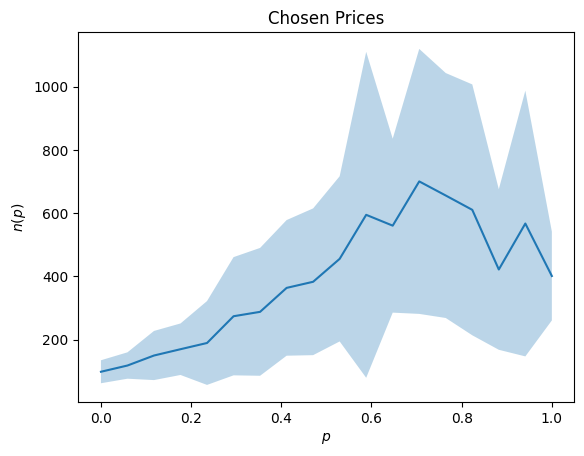

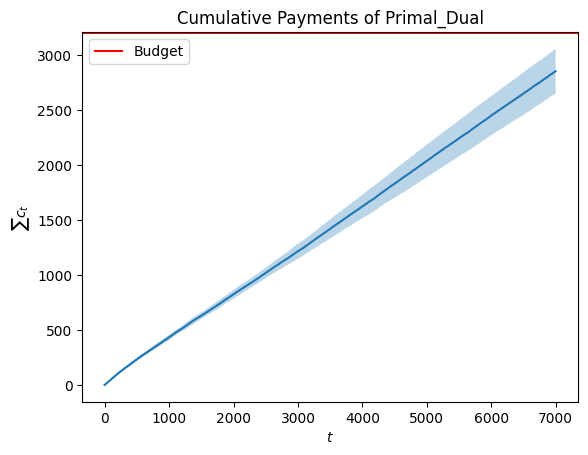

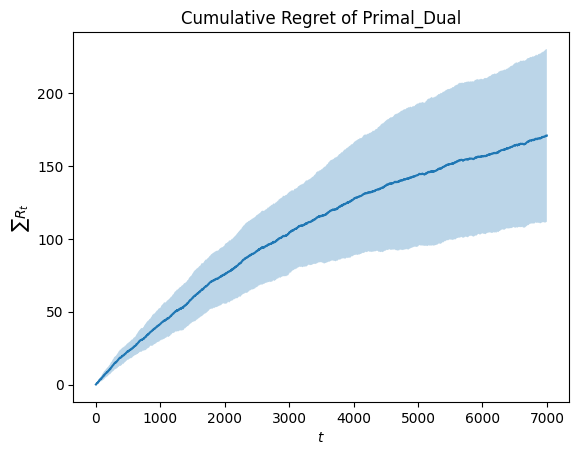

In [9]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$p$')
plt.ylabel('$n(p)$')
plt.title('Chosen Prices')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Primal_Dual')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Primal_Dual')
plt.show()

## Chosen Prices

The graph shows a peak at around 0.7. The uncertainty is large confirming variability across runs. The uncertainty inceases specifically at the peaks.

## Cumulative Payments

Payments grow sublinearly with time and never reach the total budget before horizon T=7000.
This suggests the agent is conservative in spending, likely because the Lagrangian multiplier lambda penalizes overspending
The agent guarantees feasibility but leaves part of the budget unused.

# Cumulative Regret

Regret increases sublinearly as t grows, but the uncertainty also grows.

### Trial with Truncated Normal nonstationary environment

We try the Agent with the nonstationary Truncated Normal environment

In [ ]:
n_t = 1
T = 7000
B = 3200
rho = B/T # average budget per round
epsilon = T**(-0.33)
eta = T**(-0.5)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):

    agent = FFMultiplicativePacingAgent(prices, B, T, eta, K)
    # initializas highly non-stationary environment (Truncated Normal valuations)
    env = NonStationaryTruncNormEnv(0, prices, T)
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0
    clairv_util = []

    np.random.seed(i)
    for u in range(T):
        # computes clairvoyant benchmark distribution at time u
        gamma, exp_clairv_util = compute_clairvoyant(prices, rho, env.get_win_probabilities(u))
        if gamma is None:
            # fallback
            gamma = np.ones_like(prices) / len(prices)  # Uniform distribution
            exp_clairv_util = np.sum((prices - 0) * env.get_win_probabilities(u) * gamma)
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(u, n_t, my_price)
            agent.update(f_t, c_t)  # update agent with observed outcome
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        clairv_util.append(exp_clairv_util)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    expected_clairvoyant_utility = np.array(clairv_util)
    print(f'Total # of Wins: {total_wins}')

    # stores cumulative performance measures
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)


Total # of Wins: 3167
Total # of Wins: 2810
Total # of Wins: 2994
Total # of Wins: 2892
Total # of Wins: 2857
Total # of Wins: 2725
Total # of Wins: 3001
Total # of Wins: 2716
Total # of Wins: 2740
Total # of Wins: 3015
Total # of Wins: 2984
Total # of Wins: 2950
Total # of Wins: 3100
Total # of Wins: 2570
Total # of Wins: 2758
Total # of Wins: 2284
Total # of Wins: 2865
Total # of Wins: 3019
Total # of Wins: 2912
Total # of Wins: 3155


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_23868\2402125577.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_23868\2402125577.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


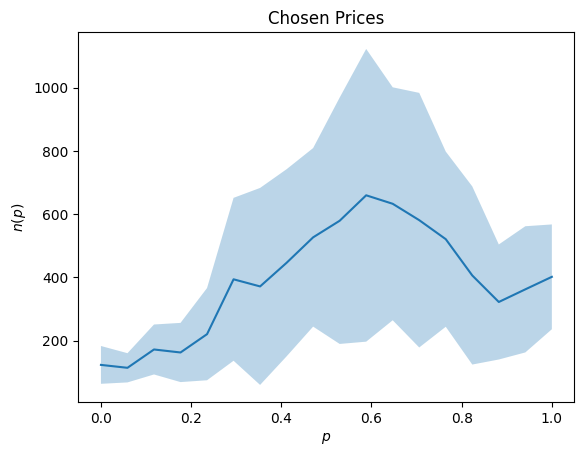

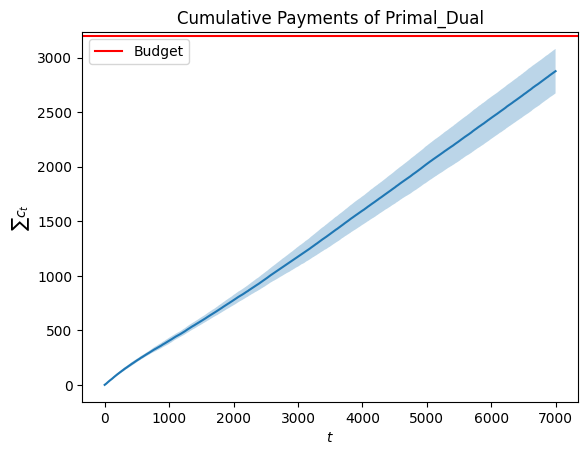

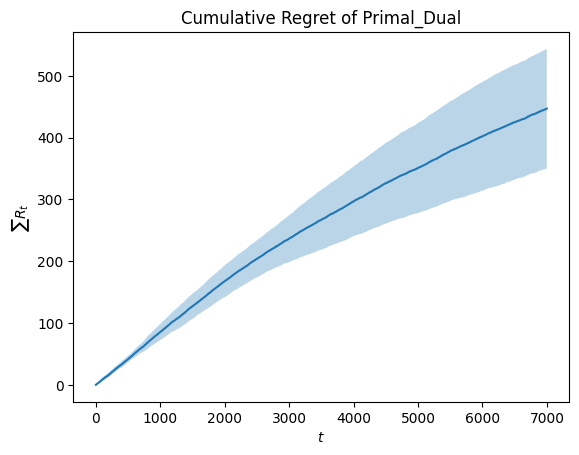

In [11]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$p$')
plt.ylabel('$n(p)$')
plt.title('Chosen Prices')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Primal_Dual')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Primal_Dual')
plt.show()

## Chosen Prices

The plot shows one main peak around a preferred price point but the shaded area (uncertainty) remains large, indicating variability across different runs and the agent not always converging smoothly to the same pricing strategy.
The concentration around ont peak suggests that the agent identifies this region as a good balance between price and win probability in the truncated normal environment. The large uncertainty comes from the EXP3.P exploration exploitation mechanism, which introduces randomness, and from the nonstationary nature of the environment, which shifts the optimal choice over time. For this reason the agent never fully locks onto a single price but keeps adapting.

## Cumulative Payments

Payments increase over time but at a sublinear rate and the payments never reach the budget line (B = 3200) within the 7000 rounds.
This sublinear growth indicates the pacing strategy is conservative with spending. The agent is cautious in allocating budget over time and avoids overspending early. 
While this prevents budget exhaustion it also implies underutilization of available resources. The agent leaves some budget unused by the end and this can be seen as either a desirable property (safe pacing) or a limitation (inefficiency in exploiting budget).

## Cumulative Regret

Regret grows over time but remains sublinear meaning the average regret per round decreases. The shaded region (uncertainty) widens as time progresses indicating increasing variability between runs.
Sublinear growth is consistent with the no-regret guarantee of EXP3.P-type algorithms while the widening uncertainty band is expected in nonstationary environments, where the benchmark itself changes over time. 

### Trial with Truncated Exponential nonstationary distribution

We try the Agent with the nonstationary Truncated Exponential environment

In [ ]:
n_t = 1
T = 7000
B = 3200
rho = B/T
epsilon = T**(-0.33)
eta = T**(-0.5)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):

    # initializes pacing agent and nonstationary truncated exponential environment
    agent = FFMultiplicativePacingAgent(prices, B, T, eta, K)
    env = NonStationaryTruncExpEnv(0, prices, T)
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0
    clairv_util = []

    np.random.seed(i)
    for u in range(T):
        # computes clairvoyant expected utility at time u
        gamma, exp_clairv_util = compute_clairvoyant(prices, rho, env.get_win_probabilities(u))
        # if no solution found, fallback to uniform distribution
        if gamma is None:
            gamma = np.ones_like(prices) / len(prices)  # Uniform distribution
            exp_clairv_util = np.sum((prices - 0) * env.get_win_probabilities(u) * gamma)
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(u, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            # if the  agent cannot pull, default to last price (no effect)
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        clairv_util.append(exp_clairv_util)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    expected_clairvoyant_utility = np.array(clairv_util)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)


Total # of Wins: 2004
Total # of Wins: 1991
Total # of Wins: 1858
Total # of Wins: 1895
Total # of Wins: 2124
Total # of Wins: 1774
Total # of Wins: 2485
Total # of Wins: 2196
Total # of Wins: 1987
Total # of Wins: 1980
Total # of Wins: 2086
Total # of Wins: 2009
Total # of Wins: 2074
Total # of Wins: 1783
Total # of Wins: 1540
Total # of Wins: 2058
Total # of Wins: 1553
Total # of Wins: 2713
Total # of Wins: 1735
Total # of Wins: 1982


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_23868\2402125577.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_23868\2402125577.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


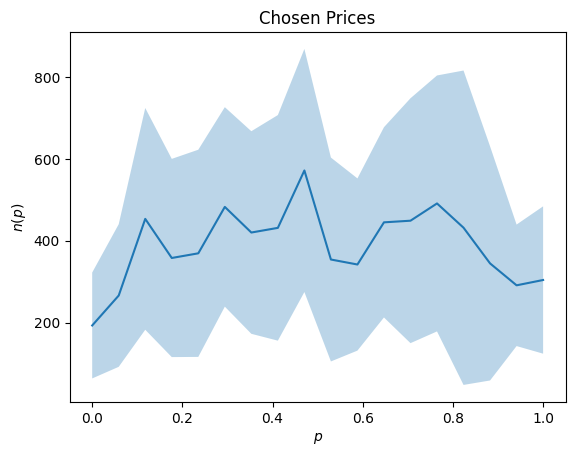

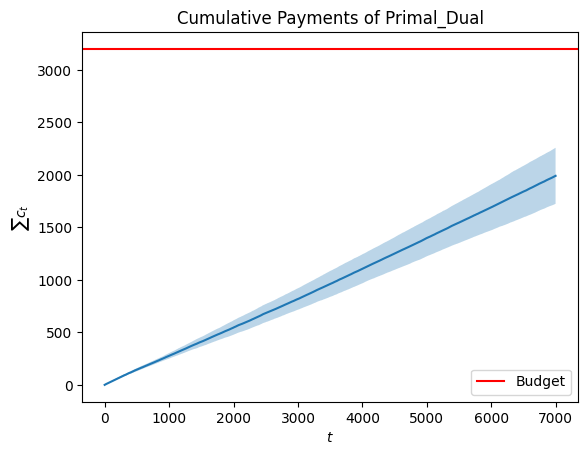

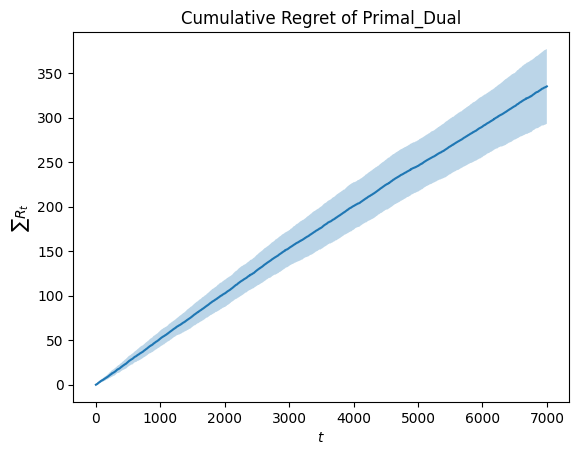

In [16]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$p$')
plt.ylabel('$n(p)$')
plt.title('Chosen Prices')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Primal_Dual')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Primal_Dual')
plt.show()

## Chosen Prices

The distribution of chosen prices shows many peaks spread across the entire range of possible prices. This indicates that the agent does not converge to a single price (unlike in the truncated normal, where there was a dominant peak). Because of this scattered behavior, the uncertainty bands remain large almost everywhere.

## Cumulative Payments

The cumulative payments grow but end very low compared to the budget line meaning the agent is spending much less than the allowed budget.
The agent stays conservative, not fully exploiting the budget, possibly because low prices yield more frequent even if small wins.

## Cumulative Regret

Regret grows in a straighter, more linear fashion compared to the truncated normal case. The uncertainty is smaller than in the previous experiments, meaning the agent’s performance is more consistent across epochs. Anyway, the regret shows sublinear growth
